# Downstream Analysis - Python

Now for the fun bit, wrangling the data and plotting our results! Below, we do this using pandas, matplotlib and statsmodels, and some convenience functions from `py_clone_detective.clone_analysis`.

First, we read in results previously generated by py_clone_detector:

In [ ]:
import pandas as pd

df = pd.read_csv('data/example_results.csv')

df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.6,0.4,73.3,False,2196457.0,True,False,False,False,False
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.6,0.4,73.3,False,52757.0,True,False,False,False,False
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.6,0.4,73.3,False,2262648.0,True,False,False,False,False
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.6,0.4,73.3,False,67331.0,True,False,False,False,False
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,486.8,0.5,98.7,False,4113516.0,True,False,False,False,False


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
count_df = df.query('int_img_ch == "C1"').filter(regex=r"clone$|pos$|int_img")

Next, we groupby clones per image and sum to get the number of cells of each type per clone.

In [ ]:
count_df = count_df.groupby(["int_img", "GFP_clone"]).sum().reset_index()
count_df.head()

,int_img,GFP_clone,GFP_clonepos,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,0,0,70,2,4,98,1
1,a1g01p1,1,14,9,0,0,5,0
2,a1g01p1,2,1,0,0,0,1,0
3,a1g01p1,3,4,1,0,0,3,0
4,a1g01p1,4,34,12,0,1,21,0


We can add a sum all cell types per clone to get an additional 'total' column:

In [ ]:
import re
# drop the unneeded "GFP column"
count_df = count_df.drop(columns="GFP_clonepos")

# calculate the total cells
count_df['total'] = count_df.filter(regex='_pos').sum(axis=1)

# simplify column names
count_df.columns = [re.sub("_pos", "", col) for col in count_df.columns]

Since where "GFP_clone" == 0, we can add an additional column stating whether a "GFP_clone" is inside a clone (*IC*) or outside a clone (*OC*):

In [ ]:
import numpy as np

count_df["clone_status"] = np.where(count_df["GFP_clone"] == 0, "OC", "IC")

Finally, the images are named 'a1' if from a wild-type (*ctrl*) animal and 'a2' if from a mutant (*mut*) animal. We can therefore add a 'genotype' column:

In [ ]:
count_df["genotype"] = np.where(count_df["int_img"].str.match(r"a1"), "ctrl", "mut")

We can groupby this genotype column and generate a stacked bar plot displaying cell numbers and types per clone. Here, we only interested in plotting cells inside clones, and so we first query on 'clone_status':

In [ ]:
count_df_inside = count_df.query('clone_status == "IC"')

inside_clone_mean = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .mean()
)

inside_clone_sem = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .sem()
)

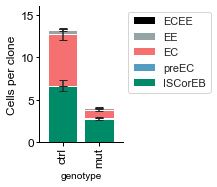

In [ ]:
import py_clone_detective.clone_analysis as ca

ca.create_stack_bar_plot(
    inside_clone_mean,
    inside_clone_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
    bar_width=0.8,
    y_axis_limit=16,
    y_label="Cells per clone",
)

From this plot we can see that 'mutant' clones are on average bigger than 'ctrl' clones. This suggests that the mutation in our gene of interest may affect **cell proliferation**. Let do a t-test using the statsmodels library to see if this difference is significant:

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
lm = ols("total ~ genotype", data=count_df_inside).fit()
lm.t_test_pairwise("genotype").result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
mut-ctrl,-9.296581,1.257855,-7.390821,7.756635e-13,-11.76894,-6.824223,7.757128e-13,True


Yes, the total number of cell per clone is significantly different in "ctrl" vs "mutant" animals. 

## Cell Differentiation - percentage cell type inside and outside clones

Next, let's investigate whether the types of cells inside and outside clones are different in ctrl and mutant animals. This information will help us determine whether our gene of interest affects **cell differentiation**.

First, since we already know that 'mutant' clones possess fewer cells than 'ctrl' clones, it is helpful to summarise cell types as a percentage.

In [ ]:
percentage_df = count_df.eval(
    """EC = EC / total * 100 
    EE = EE / total * 100
    ECEE = ECEE / total * 100 
    preEC = preEC / total * 100 
    ISCorEB = ISCorEB / total * 100"""
)

Next, we plot a stacked barplot as before. However, this time we plot percentage cell types:

In [ ]:
percentage_df_mean = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .mean()
)

percentage_df_sem = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .sem()
)

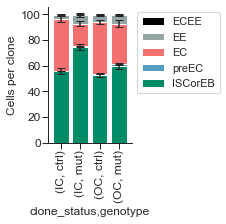

In [ ]:
ca.create_stack_bar_plot(
    percentage_df_mean,
    percentage_df_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
    bar_width=0.8,
    y_label="Cells per clone",
)

This plot suggests there might be a difference in percentage cell-types of mutant clones vs ctrl. Let's check if these differences are statistically significant.

To do this, we reshape our percentage data into a tidy format:

In [ ]:
tidy_percentage_df = pd.melt(
    percentage_df,
    id_vars=["genotype", "clone_status"],
    value_vars=["ISCorEB", "preEC", "EC", "EE", "ECEE"],
    var_name="cell_type",
    value_name="perc_cell_num",
)
tidy_percentage_df.head()

,genotype,clone_status,cell_type,perc_cell_num
0,ctrl,OC,ISCorEB,56.000000
1,ctrl,IC,ISCorEB,35.714286
2,ctrl,IC,ISCorEB,100.000000
3,ctrl,IC,ISCorEB,75.000000
4,ctrl,IC,ISCorEB,61.764706


We then create a composite column that contains genotype (g), clone_status (cs) and cell_type (ct) information.

In [ ]:
tidy_percentage_df["comp_g_cs_ct"] = (
    tidy_percentage_df["genotype"]
    + "_"
    + tidy_percentage_df["clone_status"]
    + "_"
    + tidy_percentage_df["cell_type"]
)
tidy_percentage_df.head()

tidy_percentage_df["comp_g_cs_ct"] = tidy_percentage_df["comp_g_cs_ct"].astype(
    "category"
)

We next set up a contrast matrix for our desired comparisons.

Our first set of contrasts compares the percentage of each cell type <u>inside mutant vs ctrl</u> clones:

In [ ]:
contrasts = [
    "mut_IC_EC-ctrl_IC_EC",
    "mut_IC_EE-ctrl_IC_EE",
    "mut_IC_preEC-ctrl_IC_preEC",
    "mut_IC_ISCorEB-ctrl_IC_ISCorEB",
    "mut_IC_ECEE-ctrl_IC_ECEE"
]

We would also like to compare the percentage of each cell type <u>outside mutant vs inside mutant</u> clones.

In [ ]:
contrasts = contrasts + [
    "mut_OC_EC-mut_IC_EC",
    "mut_OC_EE-mut_IC_EE",
    "mut_OC_preEC-mut_IC_preEC",
    "mut_OC_ISCorEB-mut_IC_ISCorEB",
    "mut_OC_ECEE-mut_IC_ECEE"
]

Below is a helper function to construct the values of contrast matrix:

In [ ]:
def create_contrast_matrix(desired_contrasts, df_column):
    l = list()
    levels = pd.Series(df_column.cat.categories.values)
    for contrast in desired_contrasts:
        group_A, group_B = contrast.split("-")
        l.append(levels.replace({f'^{group_A}$': -1, f'^{group_B}$': 1, ".": 0}, regex=True))
    df = pd.DataFrame(l)
    df.columns = levels.values
    df.index = desired_contrasts
    return df

We can now setup a custom contrast matrix using patsy:

In [ ]:
matrix = create_contrast_matrix(contrasts, tidy_percentage_df["comp_g_cs_ct"])
matrix.head()

,ctrl_IC_EC,ctrl_IC_ECEE,ctrl_IC_EE,ctrl_IC_ISCorEB,ctrl_IC_preEC,ctrl_OC_EC,ctrl_OC_ECEE,ctrl_OC_EE,ctrl_OC_ISCorEB,ctrl_OC_preEC,mut_IC_EC,mut_IC_ECEE,mut_IC_EE,mut_IC_ISCorEB,mut_IC_preEC,mut_OC_EC,mut_OC_ECEE,mut_OC_EE,mut_OC_ISCorEB,mut_OC_preEC
mut_IC_EC-ctrl_IC_EC,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
mut_IC_EE-ctrl_IC_EE,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0
mut_IC_preEC-ctrl_IC_preEC,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
mut_IC_ISCorEB-ctrl_IC_ISCorEB,0,0,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0
mut_IC_ECEE-ctrl_IC_ECEE,0,1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0


Finally, we use statsmodels to construct a 'ordinary least squares' (ols) model and perform t-tests for our desired contrasts:

In [ ]:
lm = ols("perc_cell_num ~ comp_g_cs_ct", data=tidy_percentage_df).fit()

t_test_df = lm.t_test(matrix).summary_frame() 
t_test_df.index = matrix.index
t_test_df.round(4) # round for easier reading

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.
mut_IC_EC-ctrl_IC_EC,63.2526,3.1975,19.7822,0.0000,56.9826,69.5226
mut_IC_EE-ctrl_IC_EE,-3.5784,1.9693,-1.8171,0.0693,-7.4400,0.2831
mut_IC_preEC-ctrl_IC_preEC,-0.3014,1.9693,-0.1530,0.8784,-4.1629,3.5602
mut_IC_ISCorEB-ctrl_IC_ISCorEB,-18.9017,1.9693,-9.5984,0.0000,-22.7633,-15.0401
mut_IC_ECEE-ctrl_IC_ECEE,0.0152,1.9693,0.0077,0.9938,-3.8464,3.8768
mut_OC_EC-mut_IC_EC,-14.1202,3.7765,-3.7390,0.0002,-21.5256,-6.7147
mut_OC_EE-mut_IC_EE,0.1986,3.7765,0.0526,0.9581,-7.2068,7.6041
mut_OC_preEC-mut_IC_preEC,-0.9642,3.7765,-0.2553,0.7985,-8.3696,6.4413
mut_OC_ISCorEB-mut_IC_ISCorEB,14.9803,3.7765,3.9667,0.0001,7.5748,22.3857
mut_OC_ECEE-mut_IC_ECEE,-0.0945,3.7765,-0.0250,0.9800,-7.5000,7.3109


However, as we are performing multiple comparisons, we need to adjust our p values. We can do that using the Benjamini/Hochberg false-discovery rate procedure:

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

fdr_results = fdrcorrection(t_test_df['P>|t|'])

t_test_df['pval_fdr_bh'] = fdr_results[1]
t_test_df['reject_fdr_bh'] = fdr_results[0]

t_test_df.round(4) # round for easier reading

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pval_fdr_bh,reject_fdr_bh
mut_IC_EC-ctrl_IC_EC,63.2526,3.1975,19.7822,0.0000,56.9826,69.5226,0.0000,True
mut_IC_EE-ctrl_IC_EE,-3.5784,1.9693,-1.8171,0.0693,-7.4400,0.2831,0.1386,False
mut_IC_preEC-ctrl_IC_preEC,-0.3014,1.9693,-0.1530,0.8784,-4.1629,3.5602,0.9938,False
mut_IC_ISCorEB-ctrl_IC_ISCorEB,-18.9017,1.9693,-9.5984,0.0000,-22.7633,-15.0401,0.0000,True
mut_IC_ECEE-ctrl_IC_ECEE,0.0152,1.9693,0.0077,0.9938,-3.8464,3.8768,0.9938,False
mut_OC_EC-mut_IC_EC,-14.1202,3.7765,-3.7390,0.0002,-21.5256,-6.7147,0.0005,True
mut_OC_EE-mut_IC_EE,0.1986,3.7765,0.0526,0.9581,-7.2068,7.6041,0.9938,False
mut_OC_preEC-mut_IC_preEC,-0.9642,3.7765,-0.2553,0.7985,-8.3696,6.4413,0.9938,False
mut_OC_ISCorEB-mut_IC_ISCorEB,14.9803,3.7765,3.9667,0.0001,7.5748,22.3857,0.0002,True
mut_OC_ECEE-mut_IC_ECEE,-0.0945,3.7765,-0.0250,0.9800,-7.5000,7.3109,0.9938,False


## Number of neighbours

In [ ]:
nc_df = df.query('int_img_ch == "C0"')
nc_df.set_index(['int_img', 'label', "GFP_clone"], inplace=True)
nc_df = nc_df.filter(regex=r'pos|tot_nc')
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'GFP'))
nc_df['cell_type'] = nc_df.filter(regex=r'pos$').idxmax(axis=1)
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'pos$'))
nc_df['genotype'] = np.where(nc_df.reset_index()["int_img"].str.match(r"a1"), "ctrl", "mut")

In [ ]:
nc_df

tot_nc  ECpos_nc  EEpos_nc  ECEEpos_nc  \
int_img label GFP_clone                                           
a1g01p1 11    0               4         3         0           0   
        12    0               4         3         0           0   
        15    0               2         0         0           0   
        17    2               2         2         0           0   
        18    0               2         1         0           0   
...                         ...       ...       ...         ...   
a2g13p3 280   0               3         2         0           0   
        281   0               3         2         0           0   
        283   0               5         2         0           0   
        285   0               3         1         0           0   
        286   0               3         1         0           0   

                         ISCorEBpos_nc  preECpos_nc    cell_type genotype  
int_img label GFP_clone                                                    
a1g01p1 11    0                      1            0       EC_pos     ctrl  
        12    0                      1            0       EC_pos     ctrl  
        15    0                      2            0  ISCorEB_pos     ctrl  
        17    2                      0            0  ISCorEB_pos     ctrl  
        18    0                      1            0  ISCorEB_pos     ctrl  
...                                ...          ...          ...      ...  
a2g13p3 280   0                      1            0  ISCorEB_pos      mut  
        281   0                      1            0  ISCorEB_pos      mut  
        283   0                      3            0       EC_pos      mut  
        285   0                      2            0       EC_pos      mut  
        286   0                      2            0  ISCorEB_pos      mut  

[18467 rows x 8 columns]

In [ ]:
nc_df.query('tot_nc != ECpos_nc + EEpos_nc + preECpos_nc + ISCorEBpos_nc')

tot_nc  ECpos_nc  EEpos_nc  ECEEpos_nc  \
int_img label GFP_clone                                           
a1g01p1 47    0               6         2         0           1   
        61    5               3         1         0           1   
        65    5               3         0         0           1   
        73    5               5         1         1           1   
        75    5               8         3         1           1   
...                         ...       ...       ...         ...   
a2g13p2 190   0               7         0         1           1   
        193   0               5         0         0           1   
        198   0               6         1         0           1   
        203   0               5         1         1           1   
        217   0               8         0         0           1   

                         ISCorEBpos_nc  preECpos_nc    cell_type genotype  
int_img label GFP_clone                                                    
a1g01p1 47    0                      3            0       EC_pos     ctrl  
        61    5                      1            0  ISCorEB_pos     ctrl  
        65    5                      2            0  ISCorEB_pos     ctrl  
        73    5                      2            0  ISCorEB_pos     ctrl  
        75    5                      3            0       EC_pos     ctrl  
...                                ...          ...          ...      ...  
a2g13p2 190   0                      5            0  ISCorEB_pos      mut  
        193   0                      4            0       EE_pos      mut  
        198   0                      4            0  ISCorEB_pos      mut  
        203   0                      2            0  ISCorEB_pos      mut  
        217   0                      7            0       EC_pos      mut  

[983 rows x 8 columns]

<AxesSubplot:xlabel='cell_type', ylabel='tot_nc'>

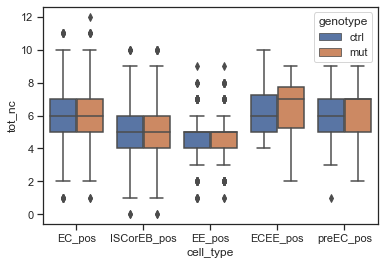

In [ ]:
import seaborn as sns

sns.boxplot(x='cell_type', y='tot_nc', hue='genotype', data=nc_df.reset_index().query('GFP_clone == 0'))